# Analytical Hierarchy Process

$\newcommand{\A}{\begin{Bmatrix}
1 & w_1 & w_2 & w_3 & w_4 \\
\frac{1}{w_1} & 1 & w_5 & w_6 & w_7 \\
\frac{1}{w_2} & \frac{1}{w_5} & 1 & w_8 & w_9 \\
\frac{1}{w_3} & \frac{1}{w_6} & \frac{1}{w_8} & 1 & w_{10} \\
\frac{1}{w_4} & \frac{1}{w_7} & \frac{1}{w_9} & \frac{1}{w_10} & 1 \\
\end{Bmatrix}}$

$A = \A$

<br>
<div class="warning" style='background-color:#E9D8FD; color: #69337A; border-left: solid #805AD5 4px; border-radius: 4px; padding:0.7em;'>

1. Put the criterions in the rows and the columns of a matrix
2. Add a score to each $w_i$ (right upper part of the table)
    * If **vertical** criterion is more important, assign the cell with **$\frac{1}{w_i}$**
    * If **horizontal** criterion is more important, assign the cell with **$w_i$**
3. Feed the function `AHP_1_Participant` with the array of $w = [w_1, w_2, w_3, ..., w_i]$ keeping the **right order** and get 3 outputs: the *table A*, the *Weights of the criterions* and the *Consistency ratio* of the AHP
4. In case of consolidated weight of multiple participants use the output A_i of the AHP of the individual participants and feed them as $A = [A_1, A_2, A_3, ..., A_i]$ into the function `AHP_Consolidated` keeping the **right order** and get the *consolidated Weights of the criterions* and the *consolidated Consistency ratio*.

</div>

# Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt

# Functions

In [20]:
def make_matrix(arr):
  """ 
  Goal:
  Transform the input to appropriate format

  Input:
  arr: the array with the weight with respect to the right order (w = w1, w2, w3, w4...)
  
  Output:
  A: Transformed the w array to get the right format of the A matrix
  """
  X = (squareform(arr)).astype(float)
  row, col = np.diag_indices(X.shape[0])
  X[row,col] = np.ones(X.shape[0])
  for i in range(0, len(row)):
      for j in range(0, len(col)):
          if j < i:
              X[i, j] = (1 / X[i, j])
  A = np.asarray(X)
  return A

def AHP_1_Participant(arr):
  """ 
  Goal:
  Apply the AHP only on one participant to calculate the Consistency ratio, the weights, their standard deviation and the rgmm
  
  Input:
  arr: the array with the weight with respect to the right order (w = [w1, w2, w3, w4, ..., wi])
  
  Output:
  A: Transformed the w array to get the right format of the A matrix (using the make_matrix function)
  p: A dataframe with the normalized weights of the criterions and their st. deviation and the RGMM and their standard deviation
  cr: The consistency ratio of the participant
  rggm: The RGMM values of the participant

  Plot:
  1. The A matrix with the answers to cross validate it
  2. The Consistency Ratio Matrix to detect the "suspicious" weights
  3. The consistency ration of each participant and the normalized one
  """

  alpha = 0.1
  A = make_matrix(arr)
  n = len(A)
  x_ticks = ['C{}'.format(i) for i in range(1, n+1)]
  sums = np.array(pd.DataFrame(A).sum())
  ln_rgmm = np.log(A)
  rgmm_sum = np.array(np.exp(pd.DataFrame(ln_rgmm).sum(axis = 1) / n))
  rgmm_sum_2 = rgmm_sum.sum()
  rggm = rgmm_sum / rgmm_sum_2
  errors = np.zeros(np.shape(A))
  
  size = np.shape(errors)[1]
  for i in range(0, size):
      for j in range(0, size):
          errors[i, j] = np.log(A[i, j] * rggm[j] / rggm[i]) ** 2
  
  errors_sum = np.sum(errors, 0)
  error_calc = np.sqrt(errors_sum / (size - 1))
  rggm_cosh = rggm * np.cosh(error_calc)
  rggm_cosh_sum = np.sum(rggm_cosh)
  rggm_final = rggm_cosh / rggm_cosh_sum
  rggm_matmul = np.matmul(sums, rggm)

  plus_minus = rggm * np.sinh(error_calc)/rggm_cosh_sum
  cr0 = (rggm_matmul - n)/((2.7699*n-4.3513)-n)
  eig_val = np.linalg.eig(A)[0].max()
  eig_vec = np.linalg.eig(A)[1][:,0]
  p = np.round(np.real(eig_vec/eig_vec.sum()), 3)
  cr = np.round(np.real((eig_val - n)/((2.7699 * n - 4.3513) - n)), 3)
  evt = np.real(A * size / eig_val)

  for i in range(0, size):
      for j in range(0, size):
          evt[i, j] = evt[i, j]* rggm_final[j]

  pi_pi = np.zeros(np.shape(A))
  for i in range(0, size):
      for j in range(0, size):
          pi_pi[i, j] = rggm[j] / rggm[i]

  pi_pi_A = pi_pi * A
  pi_pi_A2 = np.zeros(np.shape(A))
  for i in range(0, size):
      for j in range(0, size):
          if pi_pi_A[i, j] > 1/9 and pi_pi_A[i, j] < 9:
              if pi_pi_A[i, j] > 1:
                  pi_pi_A2[i, j] = A[i, j] * pi_pi[i, j]
              else:
                  pi_pi_A2[i, j] = 1 / (A[i, j] * pi_pi[i, j])
          else:
              pi_pi_A2[i, j] = 0
  Consistency_ratio = list(pi_pi_A2[np.triu_indices(n, k = 1)])
  std = np.array(pd.DataFrame(evt).std(1))
  plt.title('A')
  g1 = sns.heatmap(pd.DataFrame(np.tril(A)), annot=True, cmap = "viridis", cbar=False)
  g1.set_xticklabels(x_ticks)
  g1.set_yticklabels(x_ticks)
  plt.show()
  plt.title('Consistency Ratio Matrix')
  g2 = sns.heatmap(pd.DataFrame(np.tril(pi_pi_A2)), annot=True, cmap = "viridis", cbar=False)
  g2.set_yticklabels(x_ticks)
  g2.set_xticklabels(x_ticks)
  plt.show()
  p = pd.DataFrame(p, columns = ['Weights'])
  p.index = p.index + 1
  p.index = 'Crit-' + p.index.astype(str)
  p['Weights'] = p['Weights'].astype(float).map("{:.2%}".format)
  p['Weights +/-'] = std
  p['Weights +/-'] = p['Weights +/-'].astype(float).map("{:.2%}".format)
  p['RGMM'] = rggm_final
  p['RGMM'] = p['RGMM'].astype(float).map("{:.2%}".format)
  p['+/-'] = plus_minus
  p['+/-'] = p['+/-'].astype(float).map("{:.2%}".format)
  print(p)
  print(' ')
  print('Consistency Ratio: {:.2%} & Consistency Ratio of Weighted: {:.2%}'.format(cr0, cr))
  return A, p, cr, rggm

def AHP_Consolidated(A, rggm, w = 1):
  """ 
  Goal:
  Apply the AHP to multiple participants to calculate the Consistency ratio, the weights, their standard deviation and the consolidated A
  
  Input:
  A: a list containing the different A matrices (A = [A1, A2, A3, A4, ..., Ai]) (came from the AHP_1_Participant function)
  rggm: a list containing the different rgmm matrices (rggm = [rgmm1, rgmm2, rgmm3, rgmm, ..., rgmmi]) (came from the AHP_1_Participant function)
  w: the weight of the different stakeholders - Not yet implemented

  Output:
  cons_exp: The consolidated A matrix of the multiple participants
  p: A dataframe with the normalized weights of the criterions and their st. deviation
  cr: The consolidated consistency ratio

  Plot:
  1. The A matrix with the consolidated answers to cross validate it
  2. The consolidated Consistency ratio and the consunsus value

  """
  n = len(A)
  logs = []
  for i in A:
      logs.append(np.array(np.log(i)))
  cons = np.zeros(np.shape(logs[0]))
  table_rggm = pd.DataFrame(rggm)
  table_rggm_ln = -table_rggm*np.log(table_rggm)
  alphas = table_rggm_ln.sum(1)
  alpha = np.exp(np.sum(alphas)/n)
  Da = np.exp(alpha)
  gammas0 = table_rggm.sum(0)/n
  gammas = -gammas0*np.log(gammas0)
  gamma = np.exp(np.sum(gammas))
  beta = gamma/alpha
  for i in logs:
      cons += i
  cons = cons/n
  cons_exp = (np.exp(cons))
  size = np.shape(cons_exp)[1]
  x_ticks = ['C{}'.format(i) for i in range(1, size+1)]
  ahp_cor1 = np.exp((-9/(size+8)*np.log(9/(size+8))-(size-1)*(1/(size+8)*np.log(1/(size+8)))))
  ahp_cor2 = np.exp((size-n)*(-1/(size+8)*np.log(1/(size+8)))+n*(-(n+8)/(size+8)/n*np.log((n+8)/(size+8)/n)))
  ahp_cor3 = size / ahp_cor1
  it0 = (cons_exp.sum(1)/10)
  it = np.matmul(cons_exp, it0)
  scale0 = it0 / np.max(it0)
  scale = it / np.max(it)
  for i in range(20):
      it = np.matmul(cons_exp, scale)
      scale = it / np.max(it)
  
  norm = np.zeros(len(scale))
  for i in range(len(scale)):
      norm[i] = scale[i] / sum(scale)
  p = pd.DataFrame(norm, columns = ['Cons Weights'])
  sum_cols = cons_exp.sum(0)
  lamda = (sum(sum_cols*norm))
  evt = np.real(size / lamda * cons_exp)
  for i in range(0, size):
      for j in range(0, size):
          evt[i, j] = evt[i, j]* norm[j]
  std = np.array(pd.DataFrame(evt).std(1))
  cr = (lamda - len(sum_cols)) / ((2.7699*len(sum_cols)-4.3513)-len(sum_cols))
  consensus = (1/beta-1/ahp_cor3)/(1-1/ahp_cor3)
  g = sns.heatmap(pd.DataFrame(np.tril(cons_exp)), annot=True, cmap = "viridis", cbar=False)
  g.set_xticklabels(x_ticks)
  g.set_yticklabels(x_ticks)
  plt.show()
  p.index = p.index + 1
  p.index = 'Crit-' + p.index.astype(str)
  p['Cons Weights'] = p['Cons Weights'].astype(float).map("{:.2%}".format)
  p['Weights +/-'] = std
  p['Weights +/-'] = p['Weights +/-'].astype(float).map("{:.2%}".format)
  print(p)
  print(' ')
  print('Consistency Ratio of Consolidated: {:.2%} \nConsensus: {:.2%}'.format(cr, consensus))
  return cons_exp, p, cr

# Participant 1

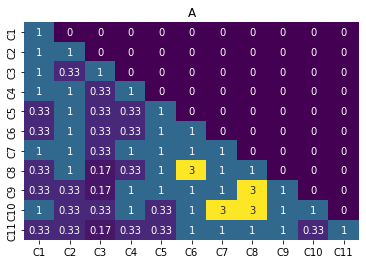

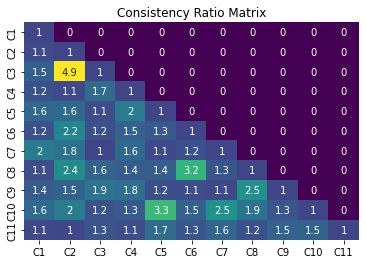

        Weights Weights +/-    RGMM     +/-
Crit-1   12.50%       4.33%  12.50%   4.42%
Crit-2   14.00%      14.23%  13.46%   8.32%
Crit-3   19.50%       8.07%  20.53%  11.13%
Crit-4   10.50%       4.36%  10.43%   4.12%
Crit-5    7.60%       5.58%   7.40%   3.68%
Crit-6    5.40%       2.74%   5.39%   2.53%
Crit-7    6.50%       2.99%   6.48%   2.86%
Crit-8    5.50%       4.00%   5.36%   2.97%
Crit-9    6.10%       3.26%   6.05%   2.60%
Crit-10   8.30%       4.54%   8.54%   4.76%
Crit-11   3.90%       1.15%   3.85%   1.20%
 
Consistency Ratio: 10.33% & Consistency Ratio of Weighted: 10.20%


In [21]:
arr = [1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 6, 6, 3, 6, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 0.333, 1, 1, 1, 1, 1, 0.333, 1, 0.333, 0.333, 1, 1, 1, 3]
A1, weights, cr, rgmm1 = AHP_1_Participant(arr)

# Participant 2

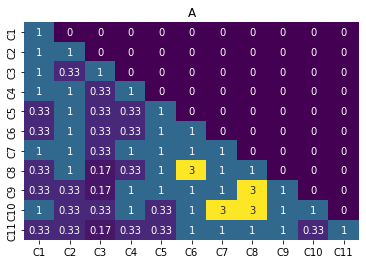

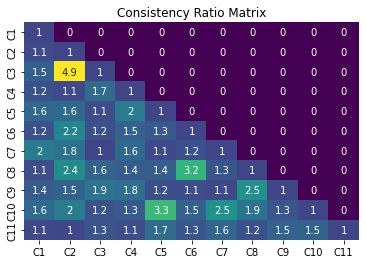

        Weights Weights +/-    RGMM     +/-
Crit-1   12.50%       4.33%  12.50%   4.42%
Crit-2   14.00%      14.23%  13.46%   8.32%
Crit-3   19.50%       8.07%  20.53%  11.13%
Crit-4   10.50%       4.36%  10.43%   4.12%
Crit-5    7.60%       5.58%   7.40%   3.68%
Crit-6    5.40%       2.74%   5.39%   2.53%
Crit-7    6.50%       2.99%   6.48%   2.86%
Crit-8    5.50%       4.00%   5.36%   2.97%
Crit-9    6.10%       3.26%   6.05%   2.60%
Crit-10   8.30%       4.54%   8.54%   4.76%
Crit-11   3.90%       1.15%   3.85%   1.20%
 
Consistency Ratio: 10.33% & Consistency Ratio of Weighted: 10.20%


In [22]:
arr = [1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 6, 6, 3, 6, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 0.333, 1, 1, 1, 1, 1, 0.333, 1, 0.333, 0.333, 1, 1, 1, 3]
A2, weights, cr, rgmm2 = AHP_1_Participant(arr)

# Consolidated Weigths

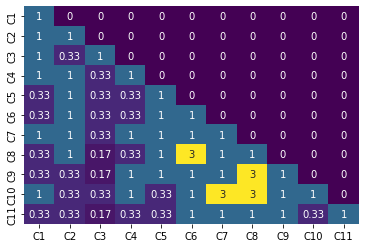

        Cons Weights Weights +/-
Crit-1        12.53%       4.39%
Crit-2        14.00%      13.44%
Crit-3        19.54%       8.25%
Crit-4        10.51%       4.59%
Crit-5         7.65%       5.45%
Crit-6         5.41%       2.83%
Crit-7         6.49%       3.09%
Crit-8         5.54%       4.10%
Crit-9         6.15%       3.38%
Crit-10        8.32%       4.60%
Crit-11        3.86%       1.19%
 
Consistency Ratio of Consolidated: 10.23% 
Consensus: 100.00%


In [23]:
cons_A, p, cr = AHP_Consolidated([A1, A2], [rgmm1, rgmm2])

# One more example

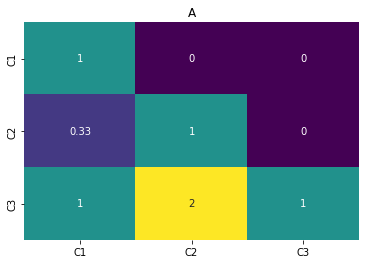

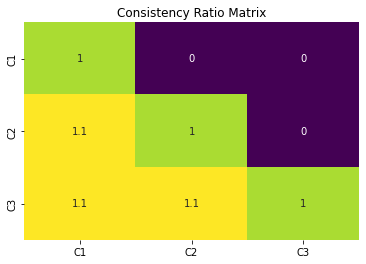

       Weights Weights +/-    RGMM    +/-
Crit-1  44.30%       5.98%  44.34%  5.96%
Crit-2  16.90%       2.28%  16.92%  2.27%
Crit-3  38.70%       5.22%  38.74%  5.20%
 
Consistency Ratio: 1.91% & Consistency Ratio of Weighted: 1.90%


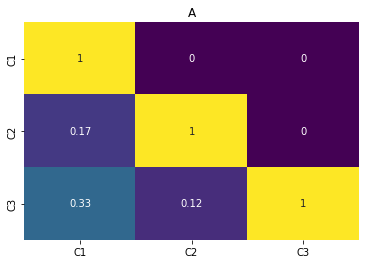

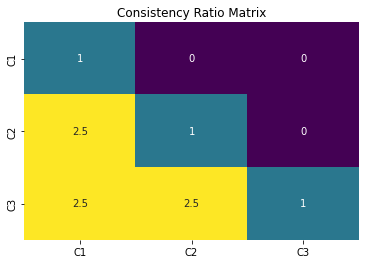

       Weights Weights +/-    RGMM     +/-
Crit-1  64.40%      53.98%  64.42%  46.89%
Crit-2  27.10%      22.67%  27.06%  19.69%
Crit-3   8.50%       7.14%   8.52%   6.20%
 
Consistency Ratio: 95.65% & Consistency Ratio of Weighted: 95.60%


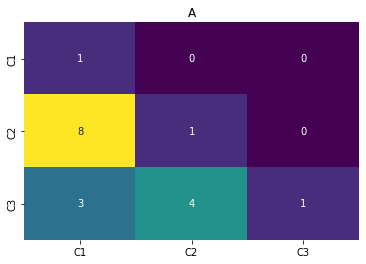

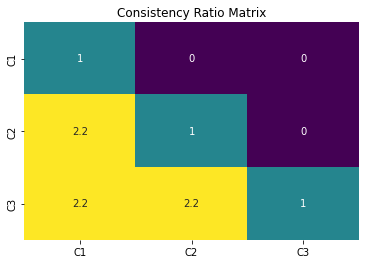

       Weights Weights +/-    RGMM     +/-
Crit-1   8.90%       6.53%   8.90%   5.85%
Crit-2  32.30%      23.72%  32.34%  21.27%
Crit-3  58.80%      43.10%  58.76%  38.66%
 
Consistency Ratio: 68.40% & Consistency Ratio of Weighted: 68.40%


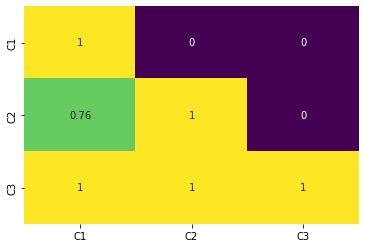

       Cons Weights Weights +/-
Crit-1       36.38%       3.27%
Crit-2       30.38%       2.73%
Crit-3       33.24%       2.99%
 
Consistency Ratio of Consolidated: 0.85% 
Consensus: 62.29%


In [24]:
A11, weights, cr, rgmm11 = AHP_1_Participant([3, 1, 1/2])
A12, weights, cr, rgmm12 = AHP_1_Participant([6, 3, 8])
A13, weights, cr, rgmm13 = AHP_1_Participant([1/8, 1/3, 1/4])

cons_A, p, cr = AHP_Consolidated([A11, A12, A13], [rgmm11, rgmm12, rgmm13])